## SOTorch using L2 

This code retrieves a surface map from reflection integrated light curve of an Earth analog.

See 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  

You need healpy, pytorch, sot package https://github.com/HajimeKawahara/sot.  
Add sot/sot/core in your PYTHONPATH.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
import torch
import torch.optim as optim
from sot.core import mocklc

In [3]:
#set geometry
inc=0.0
Thetaeq=np.pi
zeta=np.pi/3.0
                                                                                                
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
#Porb=365.242190402                                            
Porb=40.0
worb=2*np.pi/Porb                                                                                                                
N=1024
obst=np.linspace(0.0,Porb,N)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


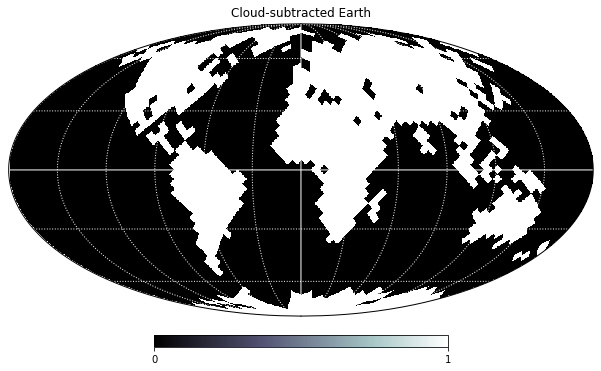

In [4]:
# test map
nside=16
mmap=hp.read_map("../data/mockalbedo16.fits")
mask=(mmap>0.0)
mmap[mask]=1.0
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [5]:
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)
WI,WV=mocklc.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
W=WV[:,:]*WI[:,:]
lc=np.dot(W,mmap)

sigma=np.mean(lc)*0.0
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

No handles with labels found to put in legend.


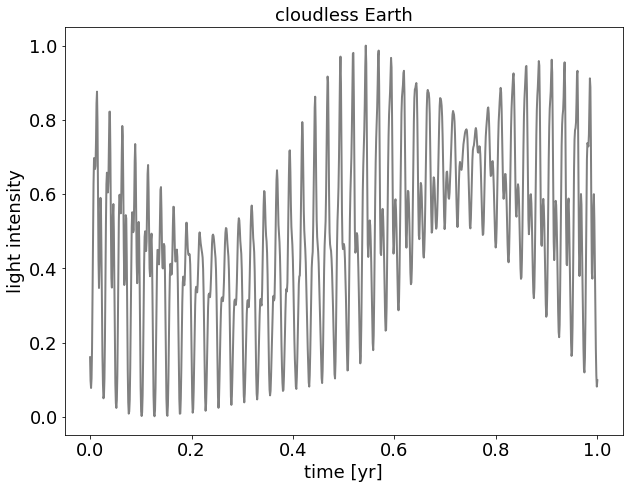

In [6]:
fig= plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [7]:
m=torch.randn(np.shape(mmap), requires_grad = True)

In [8]:
Wt=torch.from_numpy(W).float() 
lct=torch.from_numpy(lc)
lam=2.0
Q = torch.sum((lct - torch.mv(Wt,m))**2) + lam*torch.sum(m*m)
Q.backward()

In [9]:
op = optim.Adam([m],lr=0.01)

In [10]:
for i in range(0,10000):
    Q = torch.sum((lct - torch.mv(Wt,m))**2) + lam*torch.sum(m*m)
    op.zero_grad()
    Q.backward()
    op.step()
    

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


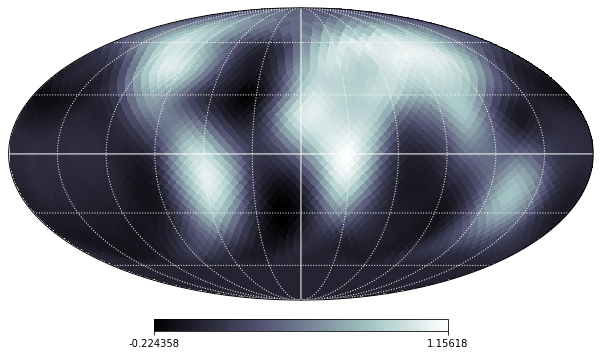

In [11]:
mnp=m.detach().numpy()
hp.mollview(mnp, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");